In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense

load the small and large data


In [3]:
large_X_raw = np.load('drive/MyDrive/train.npy', allow_pickle=True)
large_y = pd.read_csv('drive/MyDrive/train_labels.csv')['label'].values

scaler_large = StandardScaler()
large_X = scaler_large.fit_transform(large_X_raw).T  # shape: (features, samples)

In [4]:
df_small = pd.read_csv('drive/MyDrive/optdigits_8x8.csv')
small_X_raw = df_small.iloc[:, :-1].values
small_y = df_small.iloc[:, -1].values

scaler_small = StandardScaler()
small_X = scaler_small.fit_transform(small_X_raw).T  # shape: (features, samples)

implementation of neural network

In [5]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.01, seed=42):
        np.random.seed(seed)
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.lr = learning_rate

        self.W1 = np.random.randn(hidden_size, input_size) * 0.01
        self.b1 = np.zeros((hidden_size, 1))
        self.W2 = np.random.randn(output_size, hidden_size) * 0.01
        self.b2 = np.zeros((output_size, 1))

    def ReLU(self, Z):
        return np.maximum(0, Z)

    def ReLU_derivative(self, Z):
        return Z > 0

    def softmax(self, Z):
        e_Z = np.exp(Z - np.max(Z, axis=0, keepdims=True))
        return e_Z / np.sum(e_Z, axis=0, keepdims=True)

    def one_hot(self, Y):
        one_hot_Y = np.zeros((Y.size, Y.max() + 1))
        one_hot_Y[np.arange(Y.size), Y] = 1
        return one_hot_Y.T

    def compute_loss(self, Y, A):
        m = Y.shape[1]
        return -np.sum(Y * np.log(A + 1e-8)) / m

    def forward(self, X):
        Z1 = np.dot(self.W1, X) + self.b1
        A1 = self.ReLU(Z1)
        Z2 = np.dot(self.W2, A1) + self.b2
        A2 = self.softmax(Z2)
        return Z1, A1, Z2, A2

    def backward(self, X, Y, Z1, A1, A2):
        m = X.shape[1]
        dZ2 = A2 - Y
        dW2 = (1/m) * np.dot(dZ2, A1.T)
        db2 = (1/m) * np.sum(dZ2, axis=1, keepdims=True)

        dZ1 = np.dot(self.W2.T, dZ2) * self.ReLU_derivative(Z1)
        dW1 = (1/m) * np.dot(dZ1, X.T)
        db1 = (1/m) * np.sum(dZ1, axis=1, keepdims=True)

        self.W1 -= self.lr * dW1
        self.b1 -= self.lr * db1
        self.W2 -= self.lr * dW2
        self.b2 -= self.lr * db2

    def fit(self, X, Y, iterations=1000, verbose=True):
        Y_oh = self.one_hot(Y)

        for i in range(iterations):
            Z1, A1, Z2, A2 = self.forward(X)
            loss = self.compute_loss(Y_oh, A2)
            self.backward(X, Y_oh, Z1, A1, A2)

            if verbose and i % 100 == 0:
                print(f"Iteration {i}: Loss = {loss:.4f}")

    def predict(self, X):
        _, _, _, A2 = self.forward(X)
        return np.argmax(A2, axis=0)

comparison of custom and built-in neural networks with respect to learning rate parameter

In [6]:
# parameters
learning_rates = [0.001, 0.01, 0.1]
f1_small_custom = []
f1_large_custom = []
f1_small_keras = []
f1_large_keras = []

for lr in learning_rates:
    # small dataset
    X_train, X_test, y_train, y_test = train_test_split(small_X.T, small_y, test_size=0.2, random_state=42, stratify=small_y)

    # Custom NN
    model = NeuralNetwork(input_size=64, hidden_size=32, output_size=10, learning_rate=lr)
    model.fit(X_train.T, y_train, iterations=500, verbose=False)
    predictions = model.predict(X_test.T)
    f1_small_custom.append(f1_score(y_test, predictions, average='macro'))

    # Keras NN
    y_train_cat = to_categorical(y_train)
    y_test_cat = to_categorical(y_test)

    keras_model = Sequential([
        Input(shape=(64,)),
        Dense(32, activation='relu'),
        Dense(10, activation='softmax')
    ])
    keras_model.compile(optimizer=SGD(learning_rate=lr), loss='categorical_crossentropy', metrics=[])
    keras_model.fit(X_train, y_train_cat, epochs=30, verbose=0)

    keras_preds = np.argmax(keras_model.predict(X_test, verbose=0), axis=1)
    f1_small_keras.append(f1_score(y_test, keras_preds, average='macro'))

    # large dataset
    X_train, X_test, y_train, y_test = train_test_split(large_X.T, large_y, test_size=0.2, random_state=42, stratify=large_y)

    # Custom NN
    model = NeuralNetwork(input_size=768, hidden_size=32, output_size=10, learning_rate=lr)
    model.fit(X_train.T, y_train, iterations=500, verbose=False)
    predictions = model.predict(X_test.T)
    f1_large_custom.append(f1_score(y_test, predictions, average='macro'))

    # Keras NN
    y_train_cat = to_categorical(y_train)
    y_test_cat = to_categorical(y_test)

    keras_model = Sequential([
        Input(shape=(768,)),
        Dense(32, activation='relu'),
        Dense(10, activation='softmax')
    ])
    keras_model.compile(optimizer=SGD(learning_rate=lr), loss='categorical_crossentropy', metrics=[])
    keras_model.fit(X_train, y_train_cat, epochs=30, verbose=0)

    keras_preds = np.argmax(keras_model.predict(X_test, verbose=0), axis=1)
    f1_large_keras.append(f1_score(y_test, keras_preds, average='macro'))

Graph

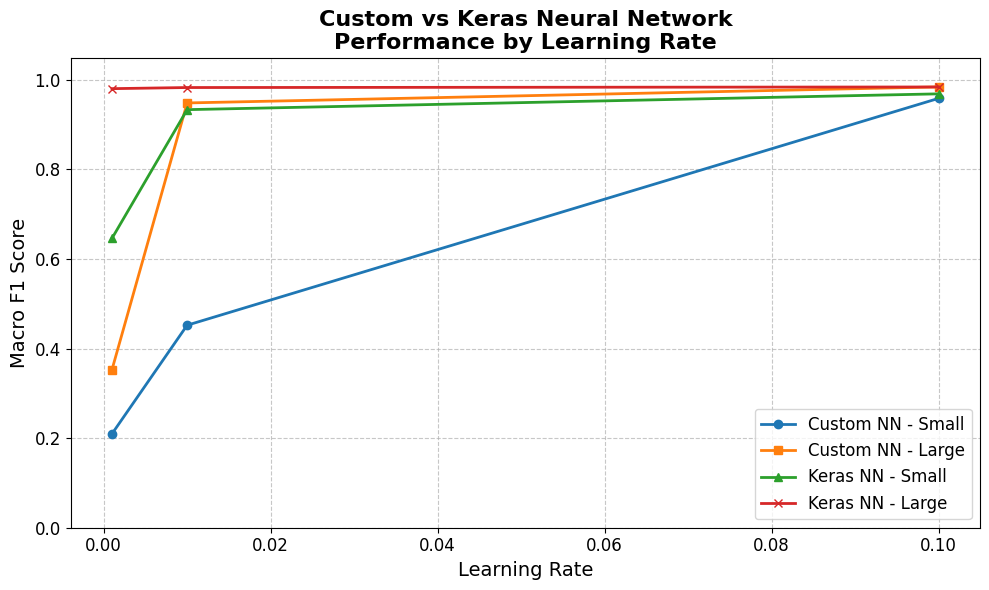

In [7]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(learning_rates, f1_small_custom, marker='o', label='Custom NN - Small', linewidth=2)
ax.plot(learning_rates, f1_large_custom, marker='s', label='Custom NN - Large', linewidth=2)
ax.plot(learning_rates, f1_small_keras, marker='^', label='Keras NN - Small', linewidth=2)
ax.plot(learning_rates, f1_large_keras, marker='x', label='Keras NN - Large', linewidth=2)

ax.set_xlabel('Learning Rate', fontsize=14)
ax.set_ylabel('Macro F1 Score', fontsize=14)
ax.set_title('Custom vs Keras Neural Network\nPerformance by Learning Rate', fontsize=16, weight='bold')
ax.legend(fontsize=12)
ax.grid(True, linestyle='--', alpha=0.7)
ax.set_ylim(0, 1.05)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()